In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import json
import math
import cv2
import PIL
from PIL import Image
import seaborn as sns
sns.set(style='darkgrid')
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from sklearn.decomposition import PCA

%matplotlib inline

Using TensorFlow backend.


In [2]:
'''
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)
'''

'\n# Detect hardware, return appropriate distribution strategy\ntry:\n    # TPU detection. No parameters necessary if TPU_NAME environment variable is\n    # set: this is always the case on Kaggle.\n    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()\n    print(\'Running on TPU \', tpu.master())\nexcept ValueError:\n    tpu = None\n\nif tpu:\n    tf.config.experimental_connect_to_cluster(tpu)\n    tf.tpu.experimental.initialize_tpu_system(tpu)\n    strategy = tf.distribute.experimental.TPUStrategy(tpu)\nelse:\n    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.\n    strategy = tf.distribute.get_strategy()\n\nprint("REPLICAS: ", strategy.num_replicas_in_sync)\n'

Let's see what files we have in the input directory:

In [3]:
sub = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')

In [4]:
import os
print(os.listdir("../input/siim-isic-melanoma-classification"))

['train.csv', 'train', 'tfrecords', 'jpeg', 'test.csv', 'test', 'sample_submission.csv']


In [5]:
#Loading Train and Test Data
train = pd.read_csv("../input/siim-isic-melanoma-classification/train.csv")
test = pd.read_csv("../input/siim-isic-melanoma-classification/test.csv")
print("{} images in train set.".format(train.shape[0]))
print("{} images in test set.".format(test.shape[0]))

33126 images in train set.
10982 images in test set.


In [6]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [7]:
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


Let's look at the distribution of teh target:

In [8]:
np.mean(train.target)

0.01762965646320111

So this is a binary classification problem with highly imbalanced data.

Let's take a look at a few images.

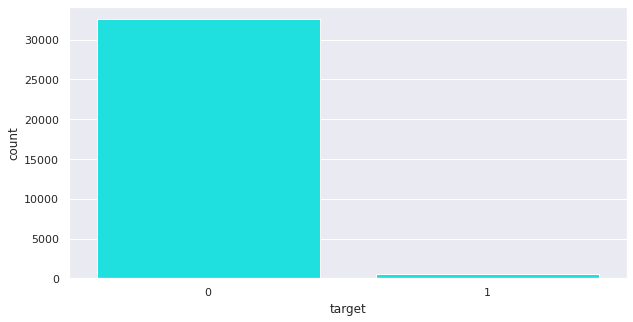

In [9]:
plt.figure(figsize=(10,5))
sns.countplot(x='target', data=train,
                   order=list(train['target'].value_counts().sort_index().index) ,
                   color='cyan')

In [10]:
train['target'].value_counts()

0    32542
1      584
Name: target, dtype: int64

In [11]:
train.columns

Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis', 'benign_malignant',
       'target'],
      dtype='object')

**Target vs Sex Distribution**

In [12]:
z=train.groupby(['target','sex'])['benign_malignant'].count().to_frame().reset_index()
z.style.background_gradient(cmap='Reds')  

,target,sex,benign_malignant
0,0,female,15761
1,0,male,16716
2,1,female,220
3,1,male,364


Now we will load some of the resized images (32x32 for now) and try to build some simple models. 

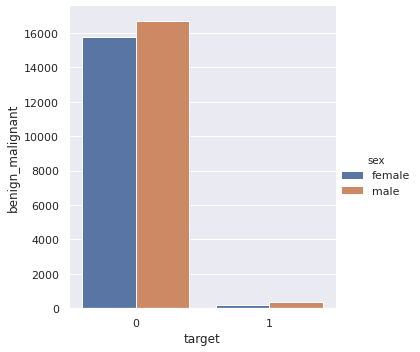

In [13]:
sns.catplot(x='target',y='benign_malignant', hue='sex',data=z,kind='bar')

**VISUALISING IMAGE DATA : JPEG**

Display random images


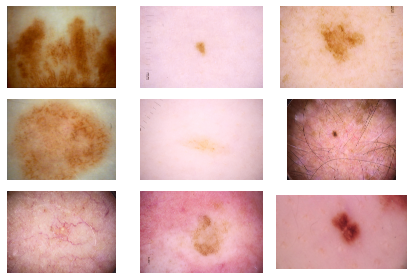

In [14]:
images= train['image_name'].values

#extract 9 random images
import random
random_images = [np.random.choice(images + '.jpg') for i in range(9)]

#location of image dir 
image_dir = '../input/siim-isic-melanoma-classification/jpeg/train'

print('Display random images')

#iterate and plot images
for i in range(9):
    plt.subplot(3,3,i+1)
    img = plt.imread(os.path.join(image_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()   

In [15]:
benign = train[train['benign_malignant']=='benign']
malignant = train[train['benign_malignant']=='malignant']

Display Benign images


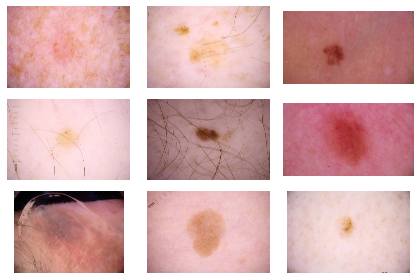

In [16]:
images= benign['image_name'].values

#extract 9 random images
import random
random_images = [np.random.choice(images + '.jpg') for i in range(9)]

#location of image dir 
image_dir = '../input/siim-isic-melanoma-classification/jpeg/train'

print('Display Benign images')

#iterate and plot images
for i in range(9):
    plt.subplot(3,3,i+1)
    img = plt.imread(os.path.join(image_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()   

Display Malignant images


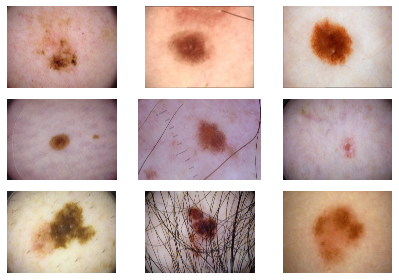

In [17]:
images= malignant['image_name'].values

#extract 9 random images
import random
random_images = [np.random.choice(images + '.jpg') for i in range(9)]

#location of image dir 
image_dir = '../input/siim-isic-melanoma-classification/jpeg/train'

print('Display Malignant images')

#iterate and plot images
for i in range(9):
    plt.subplot(3,3,i+1)
    img = plt.imread(os.path.join(image_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout() 

In [18]:
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Convolution2D,Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.callbacks import TensorBoard
from keras import applications

**TRAINING**

In [19]:
import time 

In [20]:
start=time.time()
train_images = np.load('../input/siimisic-melanoma-resized-images/x_train_96.npy')
end=time.time()
print(f"\nTime to load train images: {round(end-start,5)} seconds.")
print('Train_images shape: ',train_images.shape)


Time to load train images: 0.77591 seconds.
Train_images shape:  (33126, 96, 96, 3)


In [21]:
start=time.time()
test_images = np.load('../input/siimisic-melanoma-resized-images/x_test_96.npy')
end=time.time()
print(f"\nTime to load test images: {round(end-start,5)} seconds.")
print('Test_images shape: ',test_images.shape)


Time to load test images: 0.2563 seconds.
Test_images shape:  (10982, 96, 96, 3)


In [22]:
#target data
train_labels =np.array(train.drop(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis','benign_malignant'],axis=1))
print('Train_labels shape: ',train_labels.shape)

Train_labels shape:  (33126, 1)


In [23]:
#spliting train data
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(train_images,train_labels,test_size=0.3)

In [24]:
print('x_train shape: ',x_train.shape)
print('x_val shape: ',x_val.shape)

x_train shape:  (23188, 96, 96, 3)
x_val shape:  (9938, 96, 96, 3)


**DATA AUGMENTATION**

In [25]:
augs = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

augs.fit(x_train)

**MODELLING**

In [26]:
#annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

In [27]:
strategy = tf.distribute.get_strategy()

In [28]:
#VGG-16 MODEL NO. 1
from keras.applications.vgg16 import VGG16

input_shape=(96,96,3)
num_classes=1
tmodel_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
model = Sequential()
model.add(tmodel_base)
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='sigmoid', name='output_layer'))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

58892288/58889256 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 3, 512)         2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               2359808   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_______________________________________________________

In [29]:
#XCEPTION MODEL NO. 2
from keras.layers import Dropout, DepthwiseConv2D, MaxPooling2D, concatenate
from keras.models import Model

inp = Input(shape = (96,96, 3))
x = inp
x = Conv2D(32, (3, 3), strides = 2, padding = "same", activation = "relu")(x)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x = Conv2D(64, (3, 3), strides = 1, padding = "same", activation = "relu")(x)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)

x1 = DepthwiseConv2D((3, 3), (1, 1), padding = "same", activation = "relu")(x)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x1 = DepthwiseConv2D((3, 3), (1, 1), padding = "same", activation = "relu")(x1)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x1 = MaxPooling2D((2, 2), strides = 1)(x1)

x = concatenate([x1, Conv2D(64, (2, 2), strides = 1)(x)])

x1 = Activation("relu")(x)
x1 = Conv2D(256, (3, 3), strides = 1, padding = "same", activation = "relu")(x1)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x1 = DepthwiseConv2D((3, 3), strides = 1, padding = "same", activation = "relu")(x1)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x1 = DepthwiseConv2D((3, 3), strides = 1, padding = "same")(x1)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x1 = MaxPooling2D((2, 2), strides = 1)(x1)

x = concatenate([x1, Conv2D(256, (2, 2), strides = 1)(x)])


x = Activation("relu")(x)
x = Conv2D(256, (3, 3), strides = 1, padding = "same", activation = "relu")(x)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x = Conv2D(128, (3, 3), strides = 1, padding = "same", activation = "relu")(x)
x = BatchNormalization(axis = 3)(x)
x = Dropout(0.4)(x)
x = Flatten()(x)

x = Dense(1, activation = "sigmoid")(x)


model2 = Model(inp, x)
model2.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 48, 48, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 48, 48, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 48, 48, 32)   0           batch_normalization_3[0][0]      
____________________________________________________________________________________________

In [30]:
#DENSENET MODEL NO. 1
from tensorflow.keras.applications import DenseNet201
import tensorflow.keras.layers as L

with strategy.scope():
    dnet201 = DenseNet201(
        input_shape=(96,96, 3),
        weights='imagenet',
        include_top=False
    )
    dnet201.trainable = True

    model3 = tf.keras.Sequential([
        dnet201,
        L.GlobalAveragePooling2D(),
        L.Dense(1, activation='sigmoid')
    ])
    model3.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics=['accuracy']
    )

model3.summary()

74842112/74836368 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 3, 3, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1921      
Total params: 18,323,905
Trainable params: 18,094,849
Non-trainable params: 229,056
_________________________________________________________________


In [31]:
batch_size=128
epochs=30

history = model.fit(x_train,
             y_train,
             batch_size=batch_size,
             nb_epoch=epochs,
             verbose=1,
             validation_data=(x_val,y_val))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 23188 samples, validate on 9938 samples
Epoch 1/30
23188/23188 [==============================] - 43s 2ms/step - loss: 0.5016 - accuracy: 0.7715 - val_loss: 0.1217 - val_accuracy: 0.9818
Epoch 2/30
23188/23188 [==============================] - 37s 2ms/step - loss: 0.2167 - accuracy: 0.9582 - val_loss: 0.1853 - val_accuracy: 0.9818
Epoch 3/30
23188/23188 [==============================] - 37s 2ms/step - loss: 0.1472 - accuracy: 0.9782 - val_loss: 0.1008 - val_accuracy: 0.9819
Epoch 4/30
23188/23188 [==============================] - 37s 2ms/step - loss: 0.1318 - accuracy: 0.9773 - val_loss: 0.2424 - val_accuracy: 0.9816
Epoch 5/30
23188/23188 [==============================] - 37s 2ms/step - loss: 0.1255 - accuracy: 0.9773 - val_loss: 0.1514 - val_accuracy: 0.9819
Epoch 6/30
23188/23188 [==============================] - 37s 2ms/step - loss: 0.1098 - accuracy: 0.9800 - val_loss: 0.2502 - val_accuracy: 0.9819
Epoch 7/30
23188/23188 [==============================] - 37s 2ms/ste

In [32]:
batch_size=128
epochs=15

history3 = model2.fit(x_train,
             y_train,
             batch_size=batch_size,
             nb_epoch=epochs,
             verbose=1,
             validation_data=(x_val,y_val))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 23188 samples, validate on 9938 samples
Epoch 1/15
23188/23188 [==============================] - 130s 6ms/step - loss: 0.4640 - accuracy: 0.9636 - val_loss: 4.1637 - val_accuracy: 0.6186
Epoch 2/15
23188/23188 [==============================] - 124s 5ms/step - loss: 0.6044 - accuracy: 0.9658 - val_loss: 1.0474 - val_accuracy: 0.9809
Epoch 3/15
23188/23188 [==============================] - 124s 5ms/step - loss: 0.3383 - accuracy: 0.9695 - val_loss: 0.3881 - val_accuracy: 0.9819
Epoch 4/15
23188/23188 [==============================] - 124s 5ms/step - loss: 0.2356 - accuracy: 0.9740 - val_loss: 0.2737 - val_accuracy: 0.9803
Epoch 5/15
23188/23188 [==============================] - 124s 5ms/step - loss: 0.1976 - accuracy: 0.9750 - val_loss: 0.1106 - val_accuracy: 0.9817
Epoch 6/15
23188/23188 [==============================] - 124s 5ms/step - loss: 0.1307 - accuracy: 0.9797 - val_loss: 0.2054 - val_accuracy: 0.9642
Epoch 7/15
23188/23188 [==============================] - 124s 

In [33]:
batch_size=128
epochs=30

history3 = model3.fit(x_train,
             y_train, 
             batch_size=batch_size,
             nb_epoch=epochs,
             verbose=1,
             validation_data=(x_val,y_val))

Train on 23188 samples, validate on 9938 samples
Epoch 1/30
23188/23188 [==============================] - 86s 4ms/sample - loss: 0.0899 - accuracy: 0.9774 - val_loss: 0.0830 - val_accuracy: 0.9819
Epoch 2/30
23188/23188 [==============================] - 54s 2ms/sample - loss: 0.0734 - accuracy: 0.9825 - val_loss: 0.0789 - val_accuracy: 0.9819
Epoch 3/30
23188/23188 [==============================] - 54s 2ms/sample - loss: 0.0782 - accuracy: 0.9826 - val_loss: 0.1269 - val_accuracy: 0.9819
Epoch 4/30
23188/23188 [==============================] - 54s 2ms/sample - loss: 0.0728 - accuracy: 0.9826 - val_loss: 0.0796 - val_accuracy: 0.9818
Epoch 5/30
23188/23188 [==============================] - 54s 2ms/sample - loss: 0.0703 - accuracy: 0.9826 - val_loss: 0.0760 - val_accuracy: 0.9819
Epoch 6/30
23188/23188 [==============================] - 54s 2ms/sample - loss: 0.0688 - accuracy: 0.9826 - val_loss: 0.0769 - val_accuracy: 0.9814
Epoch 7/30
23188/23188 [==============================] -

In [34]:
model.save("vgg16.h5")

In [35]:
model.save("xception.h5")

In [36]:
model3.save("densenet.h5") 

**EVALUATION**

In [37]:
scores = model.evaluate(x_val, y_val, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.11796015205928592
Test accuracy: 0.981887698173523


In [38]:
scores = model.evaluate(x_val, y_val, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.11796015205928592
Test accuracy: 0.981887698173523


In [39]:
scores = model3.evaluate(x_val, y_val, verbose=0)
print('Test loss_3:', scores[0])
print('Test accuracy_3:', scores[1])

Test loss_3: 0.1510367915611568
Test accuracy_3: 0.95270675


**PREDICTION**

In [40]:
y_test_prob = model.predict(test_images)
pred_df = pd.DataFrame({'image_name': test['image_name'], 'target': np.concatenate(y_test_prob)})
pred_df.to_csv('submission_vgg.csv',header=True, index=False)
pred_df.head(10)

,image_name,target
0,ISIC_0052060,0.001189
1,ISIC_0052349,0.000088
2,ISIC_0058510,0.000039
3,ISIC_0073313,0.000014
4,ISIC_0073502,0.000250
5,ISIC_0074618,0.000225
6,ISIC_0076801,0.000262
7,ISIC_0077586,0.000307
8,ISIC_0082004,0.000264
9,ISIC_0082785,0.000950


In [41]:
y_test_prob2 = model3.predict(test_images)
pred_df2 = pd.DataFrame({'image_name': test['image_name'], 'target': np.concatenate(y_test_prob3)})
pred_df2.to_csv('submission_xception.csv',header=True, index=False)
pred_df2.head(10)

NameError: name 'y_test_prob3' is not defined

In [42]:
y_test_prob3 = model3.predict(test_images)
pred_df3 = pd.DataFrame({'image_name': test['image_name'], 'target': np.concatenate(y_test_prob3)})
pred_df3.to_csv('submission_dense.csv',header=True, index=False)
pred_df3.head(10)

,image_name,target
0,ISIC_0052060,1.081470e-05
1,ISIC_0052349,5.156987e-05
2,ISIC_0058510,4.207820e-08
3,ISIC_0073313,3.699467e-04
4,ISIC_0073502,4.486433e-03
5,ISIC_0074618,1.015907e-02
6,ISIC_0076801,4.887242e-04
7,ISIC_0077586,7.523847e-03
8,ISIC_0082004,3.101026e-02
9,ISIC_0082785,1.385569e-06


**ENSEMBLE**

In [43]:
en = pd.DataFrame({'image_name':test['image_name'], 'target':(0.3*pred_df['target'] + 0.3*pred_df2['target'] + 0.3*pred_df3['target'])})
en.to_csv('ensemble1.csv',header=True, index=False)
en.head(10)

NameError: name 'pred_df2' is not defined

In [44]:
hey there ffams! this is nyntbk....zzz rocks!!!1 jjjnn mufgug jk 
bjbjbkl i j ###tell mme the code: xxxxxxx

SyntaxError: invalid syntax (<ipython-input-44-816d09778616>, line 1)